We compare the agent distribution with the bead distribution for debugging purposes

In [48]:
import sys

sys.path.append("../")

In [49]:
import json
import dataclasses as dc
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

In [50]:
from functools import cached_property


@dc.dataclass
class CrosslinkDebugData:
    sim_time: float
    all_bead_pos: np.ndarray
    all_bead_ids: np.ndarray
    all_agent_pos: np.ndarray
    all_agent_ids: np.ndarray
    active_agent_ids: np.ndarray
    crosslinks: np.ndarray
    all_agent_candidates: np.ndarray
    visited_agent_candidates: np.ndarray
    visited_bead_pair_lists: list[list[tuple[int, int]]]

    @cached_property
    def active_agent_indices(self):
        return self.active_agent_ids - self.all_agent_ids.min()

    @cached_property
    def inactive_agent_indices(self):
        return np.array(
            list(
                set(range(len(self.all_agent_ids)))
                - set(self.active_agent_indices.tolist())
            )
        )

    @cached_property
    def is_agent_active(self):
        a = np.full(len(self.all_agent_ids), False)
        a[self.active_agent_indices] = True
        return a

    @cached_property
    def active_agents(self):
        return self.all_agent_pos[self.active_agent_indices]

    @cached_property
    def inactive_agents(self):
        return self.all_agent_pos[self.inactive_agent_indices]

    def __post_init__(self):
        for k, v in self.__dict__.items():
            if k in ["sim_time", "visited_bead_pair_lists"]:
                continue
            setattr(self, k, np.array(v))

In [ ]:
gel_path = Path(
    "../../data/raw/23102024_new_crosslinking_instant/old_crosslinking_chains=130/ff=none_meshw=3.0"
)
if not gel_path.exists():
    raise
debug_json_paths = sorted(
    [p for p in gel_path.rglob("debug_agents_*")],
    key=lambda p: int(p.stem.split("_")[-1]),
)
all_debug_data = [
    CrosslinkDebugData(**json.loads(p.read_text())) for p in debug_json_paths
]

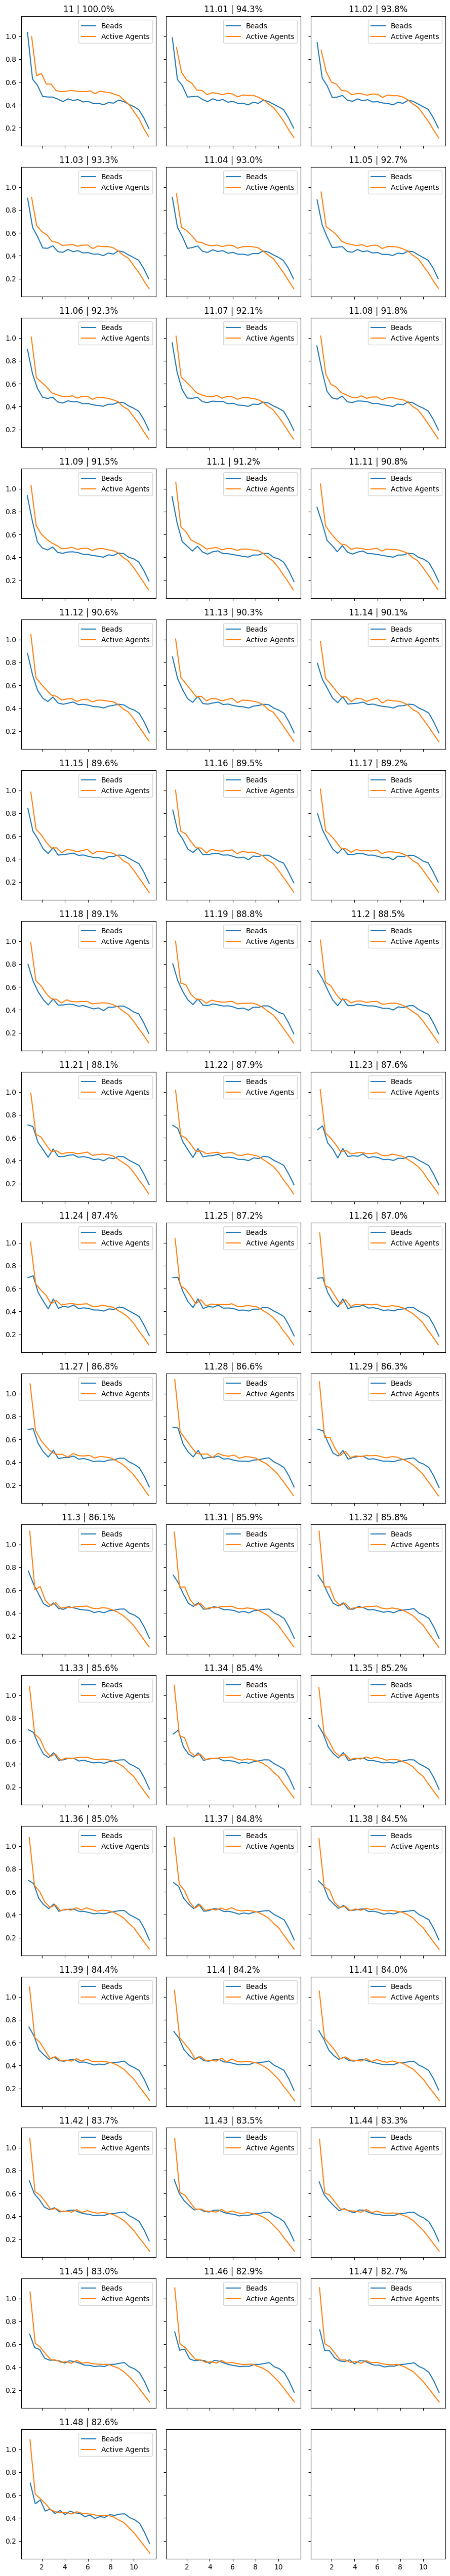

In [89]:
import importlib
from analysis import distribution

importlib.reload(distribution)

ncols = 3
nrows = len(all_debug_data) // ncols + 1
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3 * nrows), sharex=True, sharey=True
)
for i, debug_data in enumerate(all_debug_data):
    ax = axs.flat[i]
    for smooth in [True]:
        bead_rnd = distribution.compute_radial_number_density(
            all_debug_data[i].all_bead_pos, use_multi_bin_smooth=smooth
        )
        active_agent_rnd = distribution.compute_radial_number_density(
            all_debug_data[i].active_agents, use_multi_bin_smooth=smooth
        )
        ax.plot(
            bead_rnd.r,
            bead_rnd.number_density,
            "-" if smooth else "o",
            color="C0",
            label="Beads" if smooth else "",
        )
        ax.plot(
            active_agent_rnd.r,
            active_agent_rnd.number_density,
            "-" if smooth else "o",
            color="C1",
            label="Active Agents" if smooth else "",
        )
    ax.set_title(
        f"{debug_data.sim_time:g} | {len(debug_data.active_agent_ids)/len(debug_data.all_agent_ids):.1%}"
    )
    ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
agent_color = np.where(all_debug_data[1].is_agent_active, "C0", "C1")  # blue(C0)=active

ncols = 3
nrows = len(all_debug_data) // ncols + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3 * nrows))
for i, debug_data in enumerate(all_debug_data):
    ax = axs.flat[i]
    ax.set_title(
        f"{debug_data.sim_time:g} | {len(debug_data.active_agent_ids)/len(debug_data.all_agent_ids):.1%}"
    )
    ax.scatter(*debug_data.all_agent_pos[:, :2].T, color=agent_color, alpha=0.4, s=5)
    ax.set_aspect("equal")
plt.tight_layout()
plt.show()